<a href="https://colab.research.google.com/github/AbrahamAzizi/ModelBasedCompressiveSensing/blob/main/DiscreteCosine%26WaveletBasis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
size=15
parameters = {'axes.labelsize': size, 'axes.titlesize': size, 'figure.titlesize': size,
              'xtick.labelsize': size, 'ytick.labelsize': size, 'legend.fontsize': 15,
              'legend.title_fontsize': 15, 'figure.figsize':(16,4)}
plt.rcParams.update(parameters)
import seaborn as sns
import numpy as np
import seaborn as sn
from scipy.fftpack import dct, idct, fft, ifft
from scipy import linalg
from scipy import signal
from skimage.metrics import structural_similarity as SSIM
import os
import pywt
import matplotlib.animation as animation

In [ ]:
#given a liest of numpy array v 
def make_gif(v, input_shape):
#    plt.rcParams['figure.figsize'] = [8,6]
    r,c=input_shape
    plt.rc('animation', html='html5')
    fig = plt.figure(figsize=(6,4))
    s = abs(v[0].reshape(r,c))
    im = plt.imshow(s, animated=True)

    def updatefig(i):
        im.set_array(abs(v[i].reshape(r,c)))
        return im,
    anim = animation.FuncAnimation(fig, updatefig,
                                   frames=len(v),interval=200,
                                   blit=True)
#    HTML(anim.to_html5_video())
    plt.close()
    return anim

def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def img_pad(img,len_dl,len_dh):
    pad_bgn=img[:,:len_dl][:,::-1]
    pad_end=img[:,::-1][:,:len_dl]
    imgv=np.hstack((pad_bgn,img,pad_end))
    pad_up=imgv[:len_dh,:][::-1,:]
    pad_dwn=imgv[::-1,:][:len_dh,:]
    return np.vstack((pad_up,imgv,pad_dwn))

def img_dpad(imgp, len_dl,len_dh):
  return imgp[len_dl:-len_dl , len_dh:-len_dh]

# in hl and lh the left side applied on raws and right side on columns as Y=AXB^T
# so, the position of lh means raw_h and column_l hence, klh=k_01=kron(kh, kl)
# input: padded image shape, low and high pass filters
# output: kernels of ll, lh, hl and hh
def dwt2d_M(imgp_shape, lowf, highf):
    r,c= imgp_shape
    kl= np.kron(np.eye(r//2), lowf)
    kh= np.kron(np.eye(c//2), highf)
    kll= np.kron(kl, kl)
    klh= np.kron(kh, kl)
    khl= np.kron(kl, kh)
    khh= np.kron(kh, kh)
    return kll, klh, khl, khh

def soft_thresh(x, l1):
    return np.sign(x) * np.maximum(np.abs(x) - l1, 0.)

def fist(A, y, l1, maxit):
    x = np.zeros(A.shape[1])
    t = 1
    z = x.copy()
    L = linalg.norm(A, ord=2) **2
    for _ in range(maxit):
        xold = x.copy()
        r= y - A.dot(z)
        z = z + np.dot(A.T, r) / L
        x = soft_thresh(z, l1 / L)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
    return x

def amp(A, y, l1, maxit):
    x= np.zeros(A.shape[1])
    z= y
    for _ in range(maxit):
        theta = l1 * np.sqrt(linalg.norm(z)**2/len(y)) # alpha*tau
        s= x + np.dot(A.T,z)
        x= soft_thresh(s, theta)
        # update with osenger
        b= linalg.norm(x,0)/len(y)
        z= y - np.dot(A,x) + b*z
    return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Thesis/Codes/data'
dir = os.path.join(path,'100_RecordingFrames(f30tof130).npy')
with open(dir, 'rb') as f:
  rec= np.load(f)

nex=100
ney=100
l=nex*ney
t=30
v = rec[:t,:]

In [ ]:
make_gif(v.reshape((t,nex,ney)), (nex,ney))

In [ ]:
vr=np.zeros(v.shape)
for i,x in enumerate(v):
    vr[i,:]= idct(make_sparse(dct(x,norm='ortho'), l//100),norm='ortho')

In [ ]:
ps=[]
for i in range(t):
  ps.append(PSNR(v[i],vr[i]))
psnr={'sparse':ps}

In [ ]:
ss=[]
for i in range(t):
  ss.append(SSIM(v[i],vr[i]))
ssim={'sparse':ss}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until


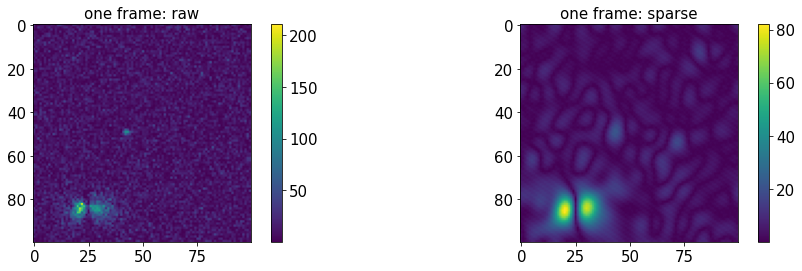

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw')
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: sparse')
plt.colorbar()

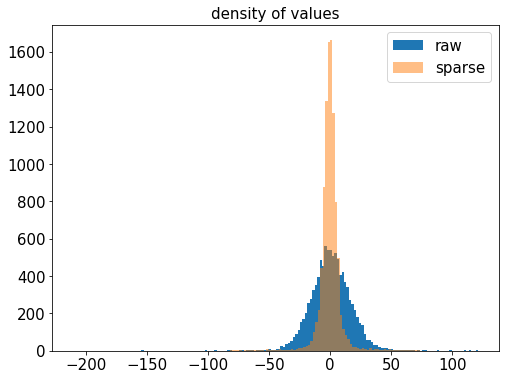

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

In [ ]:
make_gif(vr.reshape((t,nex,ney)), (nex,ney))

In [ ]:
l=nex*ney
df= idct(np.eye(nex*ney), norm='ortho')
#Mg= np.random.normal(0.0, 1/np.sqrt(2500), (2500, l))
#Mb= np.random.binomial(1, .15, size=(2500,l))
Mi= np.diag(np.random.binomial(1, .15, size=(l,)))
M=Mi
A= np.dot(M, df)

In [ ]:
l1 = 1  # regularization parameter
maxit = 1000
vr=np.zeros(v.shape)
for i,x in enumerate(v):
    print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
    y= np.dot(M, x)
    z= amp(A, y, l1, maxit)
    vr[i,:]=dct(z, norm='ortho')

 frame..........29/29

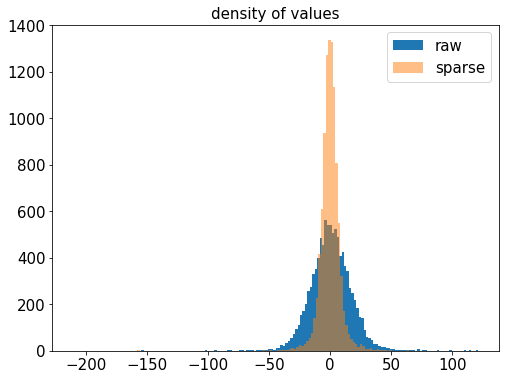

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

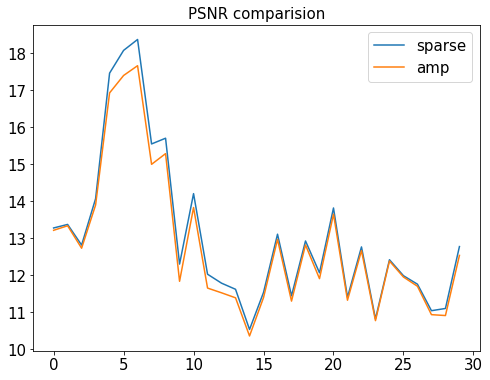

In [ ]:
ps=[]
for i in range(len(vr)):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'amp':ps})

plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['amp'], label= 'amp')
plt.title('PSNR comparision')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

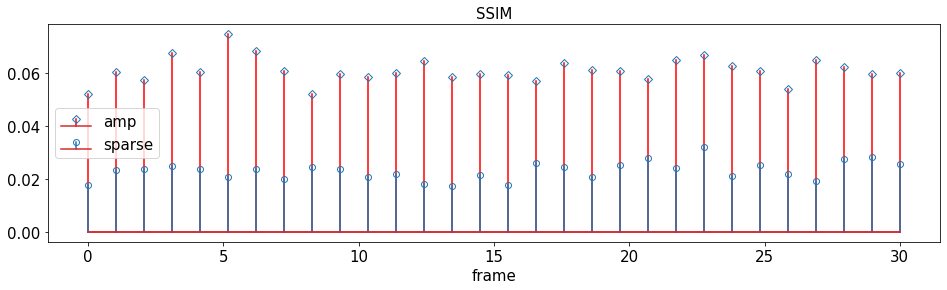

In [ ]:
ss=[]
for i in range(len(vr)):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'amp':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['amp'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='amp')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
# read filters
dl=np.array([1/np.sqrt(2), 1/np.sqrt(2)])
dh=np.array([1/np.sqrt(2), -1/np.sqrt(2)])
rl=dl
rh=-dh

# mirror pad image
imgp= img_pad(vr[5].reshape(nex,ney), len(dl), len(dh))

# build kernels
kll, klh, khl, khh= dwt2d_M(imgp.shape, dl, dh)

In [ ]:
l= imgp.shape[0]*imgp.shape[1]
M= np.diag(np.random.binomial(1, 1, size=(l,)))
All= np.dot(M, kll.T)
Alh= np.dot(M, klh.T)
Ahl= np.dot(M, khl.T)
Ahh= np.dot(M, khh.T)

In [ ]:
r=nex+len(dl)+len(dh)
c=ney+len(dl)+len(dh)
vp=np.zeros((vr.shape[0],r*c))
for i,x in enumerate(vr):
    tmp= img_pad(x.reshape(nex,ney),len(dl),len(dh))
    vp[i,:]=tmp.reshape(-1)

In [ ]:
Mw= np.diag(np.random.binomial(1, 1, size=(l,)))
l1 = 3  # regularization parameter
maxit = 1000
vs=np.zeros(v.shape)
for i,x in enumerate(vp):
    print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
    y= np.dot(Mw, x.reshape(-1))
    zll= fist(All, y, l1, maxit)
    zlh= fist(Alh, y, l1, maxit)
    zhl= fist(Ahl, y, l1, maxit)
    zhh= fist(Ahh, y, l1, maxit)
    tmp=kll.T.dot(zll.reshape(-1))+klh.T.dot(zlh.reshape(-1))+khl.T.dot(zhl.reshape(-1))+khh.T.dot(zhh.reshape(-1))
    tmp=img_dpad(tmp.reshape(imgp.shape), len(dl), len(dh))
    vs[i,:]= tmp.reshape(-1)

 frame..........29/29

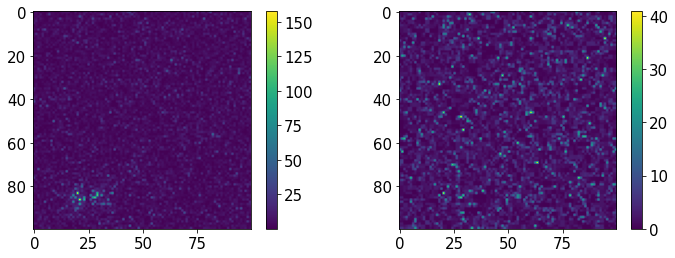

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vs[0].reshape(nex,ney)))
plt.colorbar()

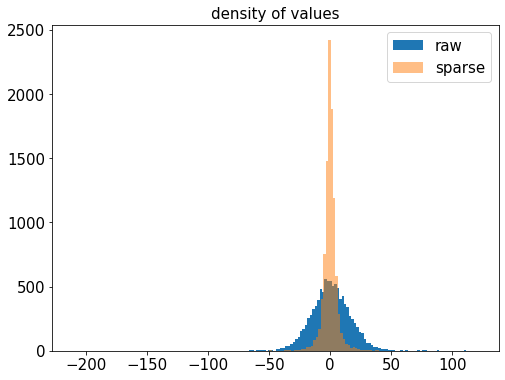

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vs[5]), np.max(vs[5]), 2)
plt.hist(vs[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

<Figure size 576x432 with 0 Axes>

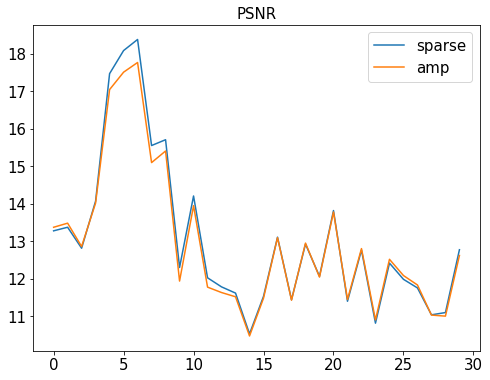

In [ ]:
ps=[]
for i in range(t):
  ps.append(PSNR(v[i],vs[i]))
psnr.update({'amp':ps})

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['amp'], label= 'amp')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

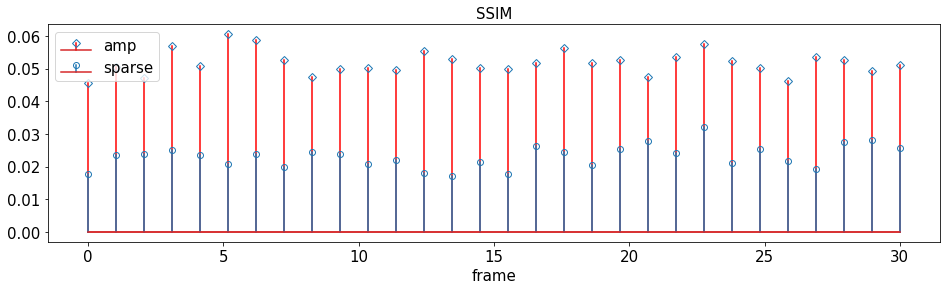

In [ ]:
ss=[]
for i in range(t):
  ss.append(SSIM(v[i],vs[i]))
ssim.update({'amp':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['amp'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='amp')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vs, (nex,ney))

In [ ]:
l1 = 1  # regularization parameter
maxit = 1000
vs=np.zeros(v.shape)
for i,x in enumerate(vp):
    print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
    y= np.dot(Mw, x.reshape(-1))
    zll= amp(All, y, l1, maxit)
    zlh= amp(Alh, y, l1, maxit)
    zhl= amp(Ahl, y, l1, maxit)
    zhh= amp(Ahh, y, l1, maxit)
    tmp=kll.T.dot(zll.reshape(-1))+klh.T.dot(zlh.reshape(-1))+khl.T.dot(zhl.reshape(-1))+khh.T.dot(zhh.reshape(-1))
    tmp=img_dpad(tmp.reshape(imgp.shape), len(dl), len(dh))
    vs[i,:]= tmp.reshape(-1)

 frame..........29/29

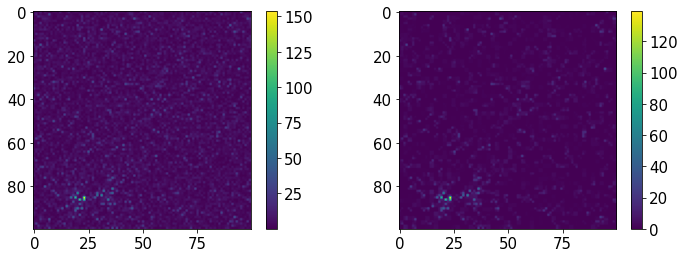

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(abs(vr[7].reshape(nex,ney)))
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vs[7].reshape(nex,ney)))
plt.colorbar()

In [ ]:
make_gif(vs, (nex,ney))

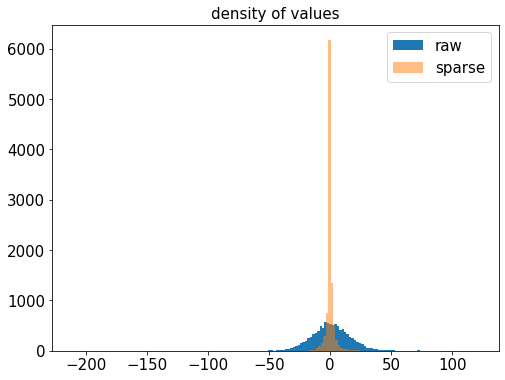

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vs[5]), np.max(vs[5]), 2)
plt.hist(vs[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

<Figure size 576x432 with 0 Axes>

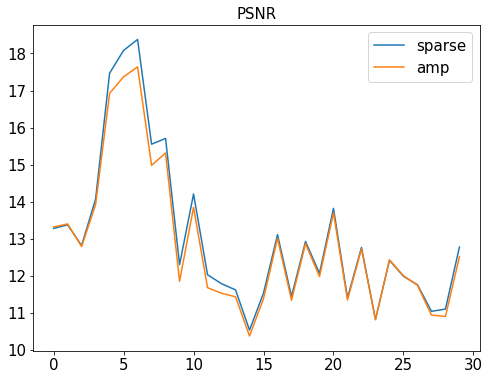

In [ ]:
ps=[]
for i in range(t):
  ps.append(PSNR(v[i],vs[i]))
psnr.update({'amp':ps})

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['amp'], label= 'amp')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

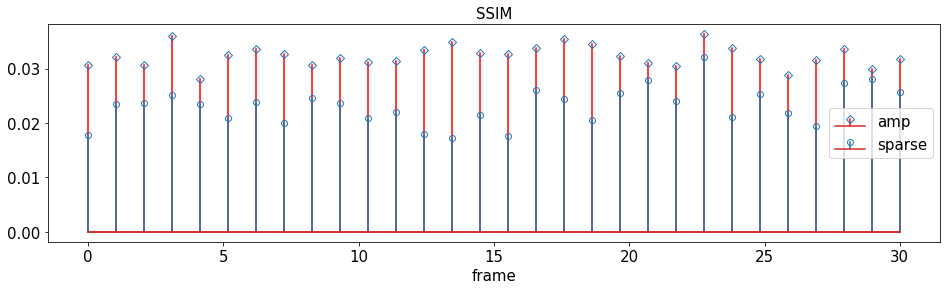

In [ ]:
ss=[]
for i in range(t):
  ss.append(SSIM(v[i],vs[i]))
ssim.update({'amp':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['amp'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='amp')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()